## CORACLE Set-up and Evaluation

In [1]:
### Data Processing

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Helper imports
import numpy as np
import pandas as pd
import os
import sys

from functools import reduce
import matplotlib.pyplot as plt

%matplotlib inline

# --- Setup Project Paths (This part remains the same) ---
current_working_dir = os.getcwd()
print(f"Current Working Directory: {current_working_dir}")
project_root = os.path.dirname(current_working_dir)
modules_path = os.path.join(project_root, 'Modules')
if modules_path not in sys.path:
    sys.path.append(modules_path)
    print(f"Added to sys.path for custom modules: {modules_path}")

####################################################################
#### Load Pre-Pivoted Log Returns Data
####################################################################

# --- Define the path to your NEW pre-processed data file ---
data_folder_path = os.path.join(project_root, 'Data')
# CHANGE 1: Use the new parquet file name
data_file_name = "log_returns_by_ticker.parquet"
data_file_path = os.path.join(data_folder_path, data_file_name)

# --- Load the data (now much simpler) ---
print(f"Loading pre-pivoted data from: {data_file_path}")

# CHANGE 2: Use read_parquet and assign directly to the final variable
returns_df_cleaned = pd.read_parquet(data_file_path)

# CHANGE 3: The following lines are NO LONGER NEEDED as the data is already clean
# returns_df.set_index('ticker', inplace=True) # Not needed
# returns_df.columns = pd.to_datetime(...)    # Not needed
# returns_df_cleaned = returns_df.dropna().transpose() # Not needed and dropna() is too aggressive here
# returns_df_cleaned.index = pd.to_datetime(...) # Not needed

# Ensure the index has a name (good practice)
returns_df_cleaned.index.name = 'date'

print("\nData loaded successfully. The format is already 'date by ticker'.")
print("Sample of the loaded log returns data (first 5 rows/cols):")
print(returns_df_cleaned.iloc[0:5, 0:5])
print(f"\nShape of the cleaned data: {returns_df_cleaned.shape}")

Current Working Directory: c:\Users\james\ICAIF_25\Current_Code\Script
Added to sys.path for custom modules: c:\Users\james\ICAIF_25\Current_Code\Modules
Loading pre-pivoted data from: c:\Users\james\ICAIF_25\Current_Code\Data\log_returns_by_ticker.parquet

Data loaded successfully. The format is already 'date by ticker'.
Sample of the loaded log returns data (first 5 rows/cols):
ticker            AA  AAA       AAC       AAG  AAI
date                                              
2000-01-03 -0.013042  0.0  0.027780 -0.024693  0.0
2000-01-04  0.010043  0.0 -0.013986 -0.003604  0.0
2000-01-05  0.047628  0.0 -0.013986  0.003604  0.0
2000-01-06 -0.011713  0.0  0.013986 -0.003604  0.0
2000-01-07 -0.016118  0.0  0.013793  0.003604  0.0

Shape of the cleaned data: (5531, 6089)


### Confounding Data

In [2]:
####################################################################
#### Constructing the dataframe for the Confounding Variables
####################################################################

"""
Data Source: Federal Reserve Economic Data (FRED)

DFF -> Federal Funds Effective Rate
T5YIE -> 5-Year Breakeven Inflation Rate (only from 2003)
USEPUINDXD -> Economic Policy Uncertainty Index for United States; News-based, 7 days moving average
VIX -> CBOE Volatility Index (VIX)
DCOILWTICO -> West Texas Intermediate (WTI) Crude Oil Prices: Cushing, Oklahoma
DTWEXBGS -> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Major Currencies (only from 2006)
DTWEXEMEGS-> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Emerging Market Economies (only from 2006)

Other Potential Data Sources:
Gold Prices (Futures/Spot), etc.
"""

files = ["DFF_20000103_20201231.csv",
         "T5YIE_20030102_20201231.csv",
         "USEPUINDXD_20000103_20201231.csv",
         "VIX_20000103_20201231.csv",
         "DCOILWTICO_20000103_20201231.csv",
         "DTWEXBGS_20060102_20201231.csv",
         "DTWEXEMEGS_20060102_20201231.csv"
         ]


merged_confound_df = reduce(
    lambda left, right: pd.merge(left, right, on="observation_date", how="outer"),
    (pd.read_csv(os.path.join(data_folder_path, f), parse_dates=[0]) for f in files)
)
imputed_confound_df = merged_confound_df.interpolate(method='linear', limit_direction='both')
imputed_confound_df.set_index('observation_date', inplace=True)
imputed_confound_df.index.name = 'date'  # Renaming index to 'date'
print("Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):")
print(imputed_confound_df.iloc[0:5,:])
print(f"Shape of the cleaned confounding variables data: {imputed_confound_df.shape}")
filtered_confound_df = imputed_confound_df[imputed_confound_df.index.isin(returns_df_cleaned.index)]
print("\n")
print("Filtering by trading dates ...")
print("\n")
print("Filtered Confounding Variables DataFrame:")
print(filtered_confound_df.head())
print(f"Shape of the filtered confounding variables data: {filtered_confound_df.shape}")

Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-01  3.99    1.3       68.04   24.21       25.56  101.4155    100.9386
2000-01-02  3.99    1.3      119.36   24.21       25.56  101.4155    100.9386
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386
2000-01-04  5.38    1.3      109.31   27.01       25.56  101.4155    100.9386
2000-01-05  5.41    1.3      123.22   26.41       24.65  101.4155    100.9386
Shape of the cleaned confounding variables data: (7671, 7)


Filtering by trading dates ...


Filtered Confounding Variables DataFrame:
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386

## ORACLE-VAR

In [ ]:
from DML_tools_copy import *

L = 0
returns_df_cleaned_prep = returns_df_cleaned.iloc[-L:]
# 2. Find the index labels that exist in BOTH DataFrames
common_index = filtered_confound_df.index.intersection(returns_df_cleaned_prep.index)
filtered_confound_df_prep = filtered_confound_df.loc[common_index]
print(filtered_confound_df_prep.head())
print(filtered_confound_df_prep.shape)

             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2016-11-01  0.41   1.59       44.68   18.56       46.66  113.9915    118.9562
2016-11-02  0.41   1.55       60.79   19.32       45.32  113.9206    119.4600
2016-11-03  0.41   1.52       63.05   22.08       44.66  113.7664    119.1730
2016-11-04  0.41   1.52       87.98   22.51       44.07  113.5828    118.9786
2016-11-07  0.41   1.56       74.75   18.71       44.88  113.5443    118.2316
(1048, 7)


In [4]:
returns_df_cleaned.iloc[-1,:]

ticker
AA      0.007074
AAA     0.000000
AAC     0.000000
AAG     0.000000
AAI     0.000000
          ...   
ZVO    -0.038615
ZWS     0.007722
ZX      0.000000
ZYME    0.022833
ZZ      0.000000
Name: 2021-12-31 00:00:00, Length: 6089, dtype: float64

In [5]:
results = parallel_rolling_window_OR_VAR_w_para_search(whole_df = returns_df_cleaned_prep, confound_df = filtered_confound_df_prep,
                                              days_valid = 2, max_threads=12)

Start time: 2025-06-28 15:12:45
Beginning search for optimal VAR order for each day
Per-day optimal VAR order (p) and corresponding validation error:
[[1008.0, 1.0, 1.0, 0.01207501119007822], [1009.0, 5.0, 1.0, 0.010724212018599862], [1010.0, 1.0, 1.0, 0.013498600374564997], [1011.0, 1.0, 1.0, 0.015443280322527585], [1012.0, 1.0, 1.0, 0.024228953438480503], [1013.0, 2.0, 1.0, 0.026905023184514387], [1014.0, 1.0, 1.0, 0.01521771528172088], [1015.0, 1.0, 1.0, 0.009778352461916096], [1016.0, 2.0, 1.0, 0.01144182876783361], [1017.0, 2.0, 1.0, 0.01337680862700948], [1018.0, 4.0, 1.0, 0.00930126603788891], [1019.0, 1.0, 1.0, 0.013296960176081155], [1020.0, 5.0, 1.0, 0.016247433950675856], [1021.0, 2.0, 1.0, 0.010896475494690427], [1022.0, 1.0, 1.0, 0.010689868503896837], [1023.0, 1.0, 1.0, 0.013557780247783794], [1024.0, 1.0, 1.0, 0.010853724051440939], [1025.0, 1.0, 1.0, 0.009326337387079707], [1026.0, 1.0, 1.0, 0.012892635817090709], [1027.0, 4.0, 1.0, 0.013782115276540377], [1028.0, 4.0, 

In [6]:
# import pickle

# # Save the dictionary
# #with open('result.pkl', 'wb') as f:
# #    pickle.dump(results, f)

# # Load the dictionary
# with open('result.pkl', 'rb') as f:
#     results = pickle.load(f)

In [7]:
## Using results, we will plot the overall PnL

# First, we compute the PnL for each day.
print(np.concatenate(results['Y_hat_next_store']))

[[-6.47e-07 -1.19e-02 -7.63e-04 ...  2.35e-04 -2.93e-02 -1.79e-04]
 [-1.54e-06  3.80e-02 -3.47e-04 ... -6.24e-04 -5.88e-02 -1.54e-03]
 [-3.49e-07 -1.11e-02 -2.70e-03 ...  3.45e-04 -1.99e-02  8.69e-05]
 ...
 [ 3.84e-08 -8.02e-03 -6.86e-04 ...  0.00e+00  1.03e-03  1.13e-05]
 [ 2.86e-08 -8.47e-03 -6.63e-04 ...  0.00e+00  1.12e-03  1.15e-05]
 [ 2.29e-08 -8.89e-03 -6.44e-04 ...  0.00e+00  1.28e-03  9.50e-06]]


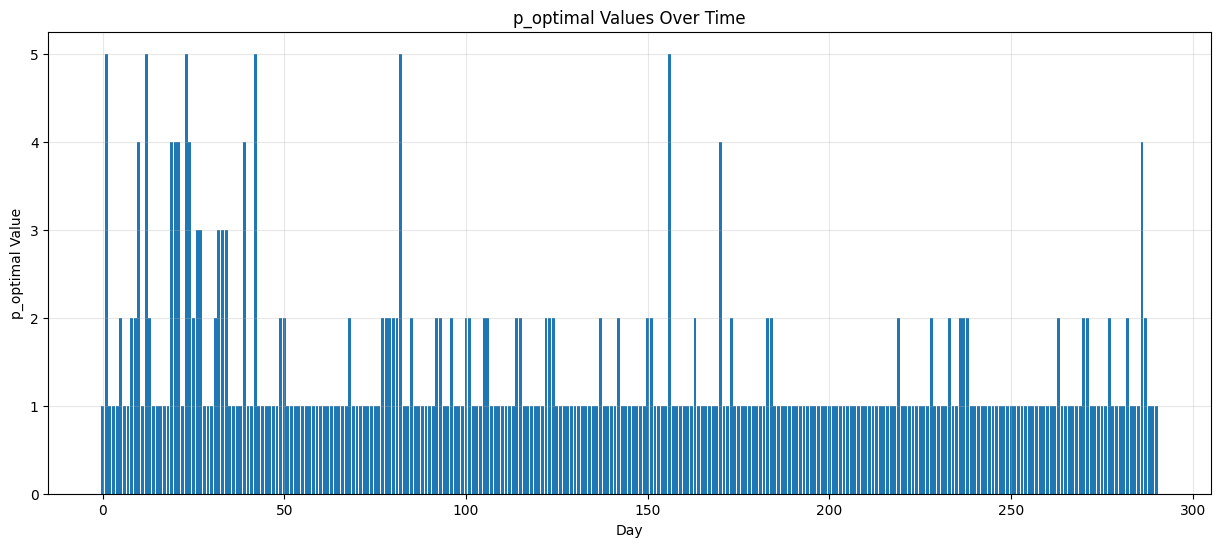

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract p_optimal from your results dictionary
p_optimal = results['p_optimal']
days = np.arange(len(p_optimal))

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(days, p_optimal)
plt.xlabel('Day')
plt.ylabel('p_optimal Value')
plt.title('p_optimal Values Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
from DML_tools import calculate_pnl
forecasted_returns = pd.DataFrame(np.concatenate(results['Y_hat_next_store']),
                                  index=returns_df_cleaned_prep.index[-L+252*4+1:])#,
                                #   columns=returns_df_cleaned_prep.columns)
actual_df = calculate_weighted_cluster_portfolio_returns(returns_df_cleaned_prep, 252*4, 20, .05)
actual_returns = actual_df.iloc[-L+252*4+1:]
print(actual_returns.equals(forecasted_returns))
print(actual_returns.head())
print(forecasted_returns.head())
print(forecasted_returns.shape)
print(actual_returns.shape)

pnl_series_n, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="naive")
pnl_series_w, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="weighted")
pnl_series_t, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="top")
print(pnl_series_n.head())

'''
Example
forecasted_returns = [[3,4],
                      [2,1],
                      [5,6]]
Each column is an asset, and each row is a day (prediction for next three days, for 2 assets)

actual_returns     = [[4,4],
                      [5,1],
                      [5,7]]

calculate_pnl returns a a series of PnL values for each day based on the strategy specified;

shape = [[1.04],
         [0.978],
         [1.01]]
    where each value is the PnL for that day based on the strategy (these are cumulative PnL)

'''

False
                  0         1             2         3         4         5   \
date                                                                         
2020-11-05  0.007197 -0.006256  1.161904e-07  0.000090  0.007136  0.002531   
2020-11-06  0.000036 -0.002785  3.857559e-07 -0.000501 -0.002877  0.002792   
2020-11-09 -0.006542  0.056608 -6.277979e-07 -0.001800 -0.021976 -0.004350   
2020-11-10  0.002854 -0.003557 -9.978522e-08  0.000004  0.004914 -0.000756   
2020-11-11 -0.014242 -0.000723  1.205534e-07  0.000795 -0.003388 -0.000164   

                      6         7    8    9    10        11            12  \
date                                                                        
2020-11-05 -8.978092e-09  0.038304  0.0  0.0  0.0 -0.004312  5.358290e-05   
2020-11-06 -1.961509e-08 -0.004991  0.0  0.0  0.0  0.003077 -2.665560e-07   
2020-11-09 -2.201944e-08 -0.017565  0.0  0.0  0.0 -0.025840 -6.544325e-05   
2020-11-10  1.763148e-08 -0.023146  0.0  0.0  0.0  0.019670 -6

'\nExample\nforecasted_returns = [[3,4],\n                      [2,1],\n                      [5,6]]\nEach column is an asset, and each row is a day (prediction for next three days, for 2 assets)\n\nactual_returns     = [[4,4],\n                      [5,1],\n                      [5,7]]\n\ncalculate_pnl returns a a series of PnL values for each day based on the strategy specified;\n\nshape = [[1.04],\n         [0.978],\n         [1.01]]\n    where each value is the PnL for that day based on the strategy (these are cumulative PnL)\n\n'

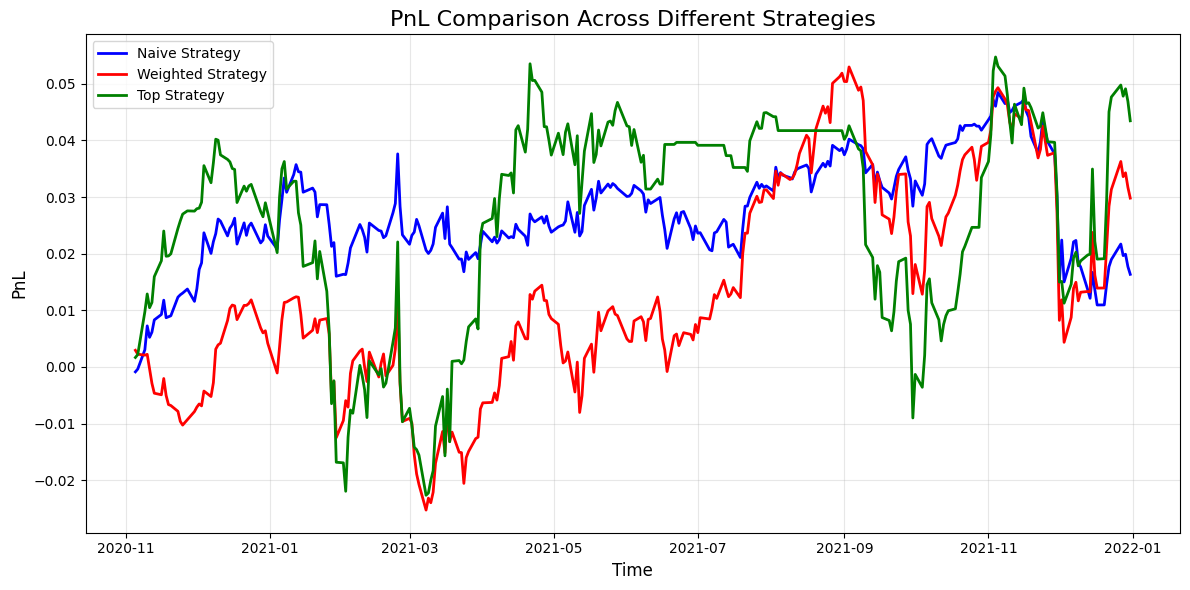

In [10]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pnl_series_n, color='blue', label='Naive Strategy', linewidth=2)
plt.plot(pnl_series_w, color='red', label='Weighted Strategy', linewidth=2)
plt.plot(pnl_series_t, color='green', label='Top Strategy', linewidth=2)

# Customize the plot
plt.title('PnL Comparison Across Different Strategies', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('pnl_comparison.png')
plt.show()

In [11]:
import numpy as np

# One-liner function
def get_metrics(series):
    daily_rets = series.diff().dropna()
    ann_ret = series.iloc[-1] * (252 / len(series))
    sharpe = (daily_rets.mean() * 252) / (daily_rets.std() * np.sqrt(252))
    return ann_ret*100, sharpe

# Get metrics for all strategies
for name, series in [("Naive", pnl_series_n), ("Weighted", pnl_series_w), ("Top", pnl_series_t)]:
    ann_ret, sharpe = get_metrics(series)
    print(f"{name}: {ann_ret:.4f}% annualized, Sharpe: {sharpe:.4f}")

Naive: 1.4164% annualized, Sharpe: 0.3454
Weighted: 2.5815% annualized, Sharpe: 0.3823
Top: 3.7637% annualized, Sharpe: 0.4478
